In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import datetime
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling1D, Dense, Input, LSTM, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy, Huber
tf.random.set_seed(42)

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
with open('882_data_new.json') as f:
    data2 = json.load(f)
df = pd.DataFrame(data2['samplings']).T
df.index = df.DateTime.astype('int').astype("datetime64[s]")
keep_cols = ['EC']

df = df[keep_cols]
col_to_float = ['EC']
for col in col_to_float:
    df[col]=df[col].astype('float64')
df = df.resample('15T').pad()
ec = df.EC
ec[ec==0] = np.nan
ec.interpolate(limit_direction='both', inplace=True)
split = int(ec.shape[0]*0.85)
train_mean = ec[:split].mean()
train_std = ec[:split].std()
print(ec.min(), ec.max())
ec = (ec-train_mean)/train_std
print(ec.min(), ec.max())
ec = ec.clip(-3, 3)
assert ec.isna().sum() == 0
target = ec.copy()
ec = ec.values.reshape(-1,1)

8.0 12280.0
-2.8949811380162296 30.286792141834347


In [5]:
train_mean, train_std

(1078.6844455268713, 369.84159636375114)

In [4]:
df.index[0], df.index[-1]

(Timestamp('2019-12-31 22:15:00', freq='15T'),
 Timestamp('2020-05-30 21:00:00', freq='15T'))

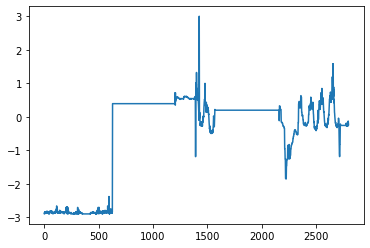

In [5]:
plt.plot(np.arange(len(ec[:2800])),ec[:2800])

In [6]:
def create_windowed_dataset(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  """
  :param history_size: he size of the past window of information
  :param target_size:  how far in the future does the model need
   to learn to predict
  """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = np.arange(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [7]:
ec[:,0].shape

(14492,)

In [8]:
hist_size = 96*2

In [9]:
X_train, y_train = create_windowed_dataset(ec, target, 0, split, hist_size, 96, 1)

In [10]:
X_val, y_val = create_windowed_dataset(ec, target, split, None, hist_size, 96, 1)

In [11]:
subseq_n = 8
time_steps_per_seq = hist_size//subseq_n

In [12]:
time_steps_per_seq

24

In [13]:
X_train.shape

(12126, 192, 1)

In [14]:
X_train = X_train.reshape(X_train.shape[0], subseq_n, time_steps_per_seq, X_train.shape[-1])
X_val   = X_val.reshape(X_val.shape[0], subseq_n, time_steps_per_seq, X_val.shape[-1])

In [15]:
X_train.shape, y_train.shape

((12126, 8, 24, 1), (12126, 96))

In [16]:
X_val.shape, y_val.shape

((1886, 8, 24, 1), (1886, 96))

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [18]:
multi_step_model = Sequential(
    [
        TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), 
                        input_shape=X_train.shape[1:]),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(32, return_sequences=True),
        LSTM(16, activation='relu'),
        Dense(96)
    ]
    )
multi_step_model.compile(optimizer='adam', loss=Huber(), metrics=["mae"])

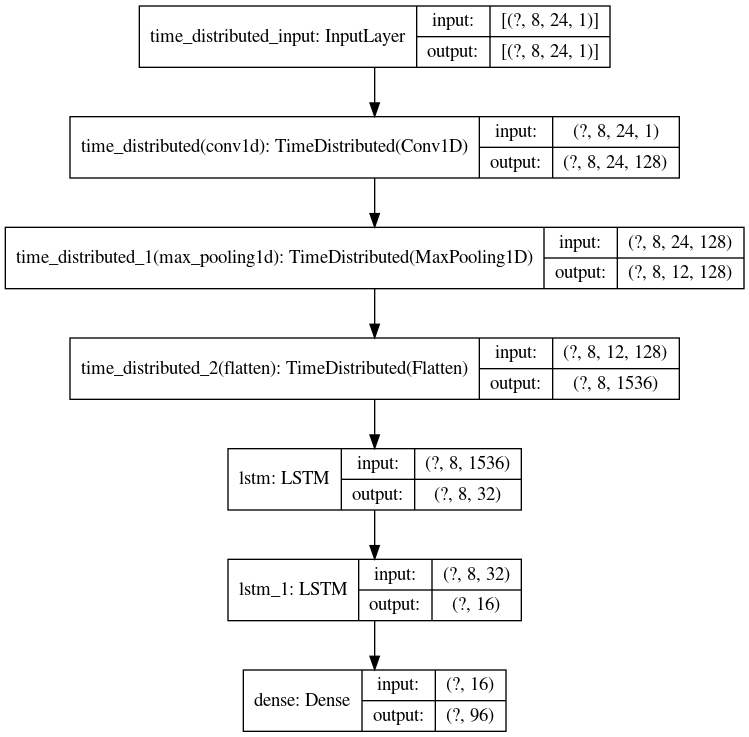

In [19]:
plot_model(multi_step_model, show_shapes=True)

In [20]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(BATCH_SIZE).prefetch(1)

In [21]:
for x, y in val_data.take(1):
  print (multi_step_model.predict(x).shape)

(64, 96)


In [22]:
multi_step_history = multi_step_model.fit(train_data, epochs=100,
                                          validation_data=val_data, callbacks=
                                           [EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                                            ReduceLROnPlateau(patience=2, verbose=1)])

Epoch 1/100
190/190 [==============================] - 12s 66ms/step - loss: 0.1496 - mae: 0.4115 - val_loss: 0.1063 - val_mae: 0.3760 - lr: 0.0010
Epoch 2/100
190/190 [==============================] - 11s 57ms/step - loss: 0.1047 - mae: 0.3314 - val_loss: 0.0683 - val_mae: 0.2893 - lr: 0.0010
Epoch 3/100
190/190 [==============================] - 11s 57ms/step - loss: 0.0900 - mae: 0.2922 - val_loss: 0.0735 - val_mae: 0.3039 - lr: 0.0010
Epoch 4/100
190/190 [==============================] - 11s 58ms/step - loss: 0.0838 - mae: 0.2780 - val_loss: 0.0671 - val_mae: 0.2873 - lr: 0.0010
Epoch 5/100
190/190 [==============================] - 12s 63ms/step - loss: 0.0796 - mae: 0.2698 - val_loss: 0.0726 - val_mae: 0.3003 - lr: 0.0010
Epoch 6/100
189/190 [============================>.] - ETA: 0s - loss: 0.0758 - mae: 0.2615
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
190/190 [==============================] - 12s 61ms/step - loss: 0.0758 - mae: 0.2615 -

In [23]:
pred = multi_step_model.predict(X_val)

In [24]:
pred

array([[ 0.9596934 ,  0.98399734,  0.9479666 , ...,  0.7017798 ,
         0.6843909 ,  0.6818747 ],
       [ 0.96637934,  0.97918034,  0.91707283, ...,  0.71244365,
         0.69417095,  0.6910529 ],
       [ 0.9695602 ,  0.9905858 ,  0.92964226, ...,  0.7103805 ,
         0.69591296,  0.69072175],
       ...,
       [-0.0206937 , -0.01953757,  0.01917536, ..., -0.1848033 ,
        -0.10296528, -0.14018579],
       [ 0.02507041,  0.00595315,  0.04265344, ..., -0.13703679,
        -0.06523684, -0.10223548],
       [ 0.05040942,  0.02677424,  0.06452613, ..., -0.10079163,
        -0.0500701 , -0.086564  ]], dtype=float32)

In [25]:
pred = train_std*pred+train_mean

In [26]:
y_val = train_std*y_val+train_mean

In [27]:
example = 100
x_axis = np.arange(len(y_val[0]))

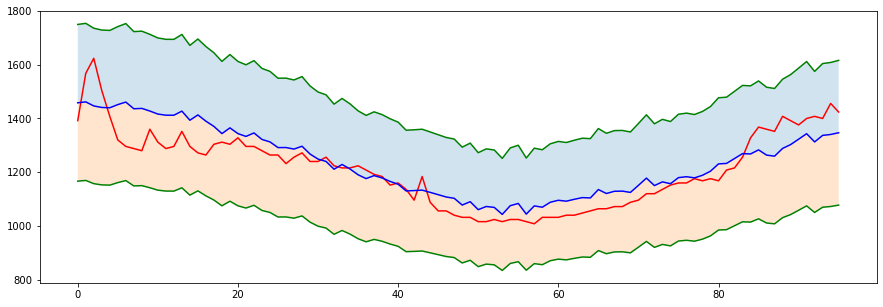

In [28]:
f, ax = plt.subplots(figsize=(15, 5))
plt.plot(x_axis, y_val[example], color='r')
plt.plot(x_axis, pred[example], color='b')
plt.plot(x_axis, pred[example]*1.2, color='g')
plt.plot(x_axis, pred[example]*0.8, color='g')
ax.fill_between(x_axis, pred[example], pred[example]*1.2, alpha=0.2)
ax.fill_between(x_axis, pred[example], pred[example]*0.8, alpha=0.2);

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
mean_absolute_percentage_error(y_val[example], pred[example])

4.573321863972774

In [31]:
val_mae = multi_step_history.history['val_mae']

In [32]:
plt.style.use('fivethirtyeight')

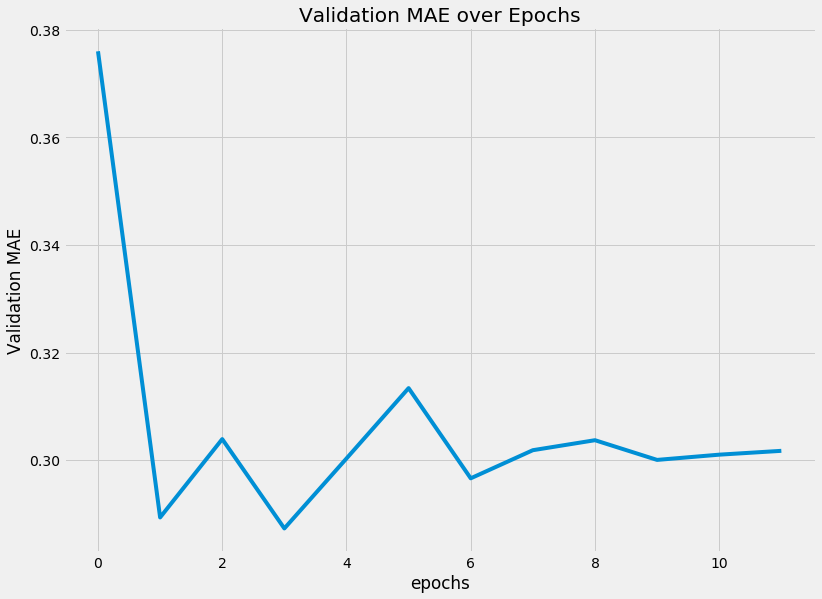

In [33]:
f = plt.figure(figsize=(12,9))
plt.plot(np.arange(len(val_mae)),val_mae)
plt.xlabel('epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE over Epochs');

In [34]:
# f.savefig('val_mae_EC_CNN_LSTM_2020_1d.png')

In [35]:
# multi_step_model.save('ec3436_CNN_LSTM_model_1d.h5')

In [36]:
mean_absolute_error(y_val, pred)

106.25503834636442